In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import LSTM, Dense, Input, GlobalAveragePooling2D, Dropout, Flatten, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

# from tensorflow.keras.layers import Input, LSTM, Dense, GlobalAveragePooling2D, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam

In [37]:
# Define paths to the folders
real_videos_path = "test-real"
deepfake_videos_path = 'test-fake'

# Initialize lists to store file names and labels
file_names = []
labels = []

# Label real videos with 0
for video in os.listdir(real_videos_path):
    file_names.append(os.path.join(real_videos_path, video))
    labels.append(0)

# Label deepfake videos with 1
for video in os.listdir(deepfake_videos_path):
    file_names.append(os.path.join(deepfake_videos_path, video))
    labels.append(1)

labels= np.array(labels)
# Create a DataFrame
data = pd.DataFrame({'file_name': file_names, 'label': labels})

# Save to a CSV file
data.to_csv('video_labels.csv', index=False)
# file_paths = np.asarray(file_names)




In [38]:
# Plot the frames

def plot_frames(frames_list):
    num_frames = len(frames_list)
    
    if num_frames == 0:
        print("No frames to display.")
        return
    plt.figure(figsize=(12, 6))
    for i, frame in enumerate(frames_list):
        plt.subplot(1, num_frames, i + 1)
        plt.imshow(frame)
        plt.axis('off')
       # plt.title(f"Frame {i + 1}")
    
    plt.show()

In [39]:
# Frame extraction
IMAGE_HEIGHT = 255
IMAGE_WIDTH = 255

def extract_frames(video_path,num_frames):
    frames = []
    
    # Read the Video File using the VideoCapture object
    video_reader = cv2.VideoCapture(video_path)
    
    # Check if the video file was opened successfully
    if not video_reader.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return frames_list
    
    # Get the total number of frames in the video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate the interval after which frames will be added to the list
    skip_frames_window = max(int(video_frames_count / num_frames), 1)
    
    # Iterate through the video frames
    for frame_counter in range(num_frames):
        # Set the current frame position of the video
        frame_pos = frame_counter * skip_frames_window
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
        
        # Read the frame from the video
        success, frame = video_reader.read()
        
        # Check if the video frame was successfully read
        if not success:
            print(f"Warning: Frame at position {frame_pos} could not be read.")
            continue
        
        # Resize the frame to fixed height and width
        resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # Normalize the resized frame by dividing it by 255 so that each pixel value lies between 0 and 1
        # normalized_frame = resized_frame / 255.0
        
        # Append the normalized frame to the frames list
        frames.append(resized_frame)
    # Release the VideoCapture object
    video_reader.release()
    frames_list = np.array(frames)
    return frames_list


In [5]:
# def video_file(file_names):
#     features = []
#     # labels = []
#     # video_files_paths = []
#     # Iterate through the list of file names
#     for file_name in file_names:  # Assuming the video file path is in the first column
#         # Get the complete video path
#         # video_file_path = os.path.join(DATASET_DIR, file_name)

#         # Extract frames from the video file
#         frames = frames_extraction(file_name[0,0])
#         # Check if the extracted frames meet the specified sequence length
#         if len(frames) == SEQUENCE_LENGTH:
#             features.append(frames)
#             # labels.append(file_names[0, -1])  # Assuming the label is in the last column
#             # video_files_paths.append(video_file_path)
    
#     # Convert lists to numpy arrays
#     features = np.asarray(features)
#     # labels = np.array(labels)
    
#     return features


In [6]:
# #model test-1

# def extract_features(frames, xception_model):
#     features = xception_model.predict(frames)
#     return features


# def load_xception_model():
#     base_model = Xception(weights='imagenet', include_top=False, input_shape=(255, 255, 3))
#     x = base_model.output
#     x = Flatten()(x)
#     model = Model(inputs=base_model.input, outputs=x)
#     model.trainable = False
#     return model
    

# def create_model(sequence_length, feature_size):
#     # Define inputs
#     video_input = Input(shape=(sequence_length, feature_size))
    
#     # Add LSTM layer
#     x = LSTM(128, return_sequences=False)(video_input)
    
#     # Add dense layer for classification
#     x = Dense(64, activation='relu')(x)
#     output = Dense(1, activation='sigmoid')(x)
    
#     # Create model
#     model = Model(inputs=video_input, outputs=output)
    
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return model


# def main(video_paths, labels, num_frames=10,model_path='lstm_model.keras'):
#     # Load Xception model for feature extraction
#     xception_model = load_xception_model()
    
#     features = []
#     for video_path in video_paths:
#         frames = extract_frames(video_path, num_frames)
#         if len(frames) == num_frames:
#             feature = extract_features(frames, xception_model)
#             features.append(feature)
    
#     features = np.array(features)
#     labels = np.array(labels)
    
#     # Define and compile the LSTM model
#     model = create_model(sequence_length=num_frames, feature_size=features.shape[-1])
    
#     # Train the model
#     hist = model.fit(features, labels, epochs=10, batch_size=16, validation_split=0.2)
#     model.save(model_path)
#     return hist

In [55]:
#model test-2

def extract_features(frames, xception_model):
    features = xception_model.predict(frames)
    return features

def load_xception_model():
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(255, 255, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.trainable = False
    return model

def create_model(sequence_length, feature_size):
    # Define inputs
    video_input = Input(shape=(sequence_length, feature_size))
    
    # Add Bidirectional LSTM layer
    x = Bidirectional(LSTM(128, return_sequences=True))(video_input)
    
    # Add another LSTM layer
    # x = LSTM(512, return_sequences=True)(video_input)
    
    # Add Dropout
    x = Dropout(0.3)(x)
    
    # Add another LSTM layer
    x = LSTM(128, return_sequences=True)(x)

    x = Dropout(0.3)(x)
    
    # Add another LSTM layer
    x = LSTM(64, return_sequences=False)(x)
    
    # Add Dense layers for classification
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(8, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)
    
    # Create and compile the model
    model = Model(inputs=video_input, outputs=output)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

def main(video_paths, labels, num_frames=10, model_path='lstm_model.keras'):
    # Load Xception model for feature extraction
    xception_model = load_xception_model()
    count = 0
    features = []
    for video_path in video_paths:
        frames = extract_frames(video_path, num_frames)
        count+=1
        print(count)
        if len(frames) == num_frames:
            feature = extract_features(frames, xception_model)
            features.append(feature)
    
    features = np.array(features)
    labels = np.array(labels)
    
    # Define and compile the LSTM model
    model = create_model(sequence_length=num_frames, feature_size=features.shape[-1])
    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='min', verbose=2
    )
    # Train the model
    hist = model.fit(features, labels, epochs=20, batch_size=1024, validation_split=0.2)
    return hist


In [56]:
file_address = pd.read_csv("video_labels.csv")

address = file_address.iloc[:,0]
labels = file_address.iloc[:,1]
address = np.array(address)
labels = np.array(labels)
print ("File loaded")
model_path = 'lstm_model.keras'
hist= main(address,labels,10,model_path)

File loaded
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
21
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
22
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
24
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
26
1/1 ━━━━━━━━━━━━━━━

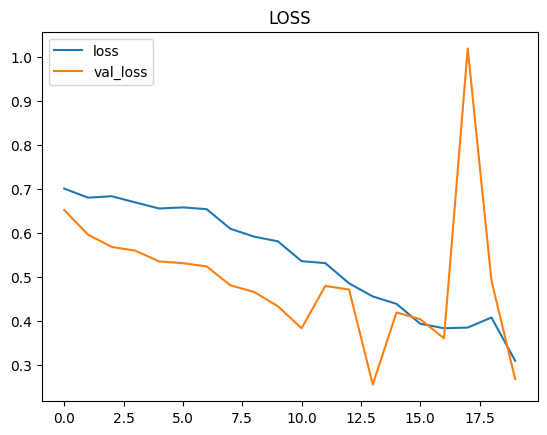

In [57]:
plt.plot(hist.history['loss'] , label = 'loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.title('LOSS')
plt.legend()
plt.show()

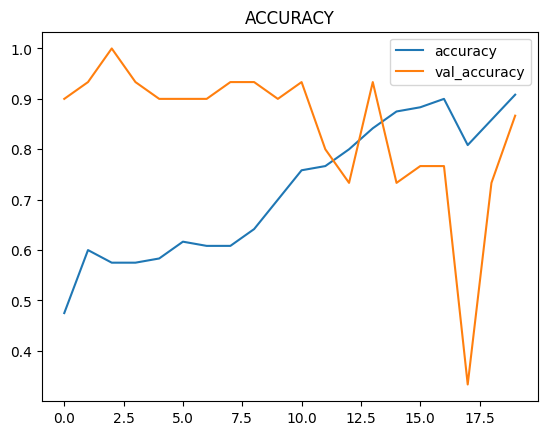

In [58]:
plt.plot(hist.history['accuracy'] , label = 'accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.title('ACCURACY')
plt.legend()
plt.show()

In [ ]:
x="Celeb-real\00227.mp4"
lstm_model = load_model('lstm_model.keras')
# Test prediction
prediction = lstm_model.predict(x)
prediction

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.xception import preprocess_input

# Assuming the functions extract_frames and preprocess_frames are defined as above

def extract_features(frames, xception_model):
    frames = preprocess_frames(frames)
    features = xception_model.predict(frames, batch_size=32)
    return features

def predict_video(video_path, xception_model, lstm_model, num_frames=10):
    frames = extract_frames(video_path, num_frames)
    if len(frames) != num_frames:
        raise ValueError(f"Video {video_path} does not have enough frames.")
    
    features = extract_features(frames, xception_model)
    features = np.expand_dims(features, axis=0)  # Add batch dimension for prediction
    prediction = lstm_model.predict(features)
    return prediction

# Save the trained model after training
def save_trained_model(model, model_path):
    model.save(model_path)

# Load the trained model
def load_trained_model(model_path):
    return load_model(model_path)

# Main code
def main(video_paths, labels, num_frames=10, model_path='lstm_model.h5'):
    xception_model = load_xception_model()
    features = []

    for video_path in video_paths:
        frames = extract_frames(video_path, num_frames)
        if len(frames) == num_frames:
            feature = extract_features(frames, xception_model)
            features.append(feature)

    features = np.array(features)
    labels = np.array(labels)
    
    # Ensure features have correct shape
    if len(features) == 0:
        raise ValueError("No valid features were extracted. Check video files and frame extraction.")
    
    model = create_model(sequence_length=num_frames, feature_size=features.shape[-1])
    
    # Train and save the model
    hist = model.fit(features, labels, epochs=10, batch_size=16, validation_split=0.2)
    save_trained_model(model, model_path)
    return hist

# Load CSV and run main function
file_address = pd.read_csv("video_labels.csv")
address = file_address['file_name'].values
labels = file_address['label'].values
print("File loaded")

# Train the model
hist = main(address, labels, 10)

# For prediction
# Load the trained model
lstm_model = load_trained_model('lstm_model.h5')

# Test prediction
test_video_path = 'path_to_test_video.mp4'
prediction = predict_video(test_video_path, load_xception_model(), lstm_model)
print(f"Prediction for {test_video_path}: {'Deepfake' if prediction[0] > 0.5 else 'Real'}")
